In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import log_loss

In [2]:
data = pd.read_csv("Apple-Twitter-Sentiment-DFE.csv", sep=';', encoding='utf-8', header = 0)
headers = data.iloc[0]
data.columns = headers
data = data.iloc[1:]
filtered_data = pd.DataFrame()
filtered_data['selected_text'] = data['text']
filtered_data['sentiment'] = data['sentiment']
data = filtered_data
data.head(10000)

,selected_text,sentiment
1,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
2,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
3,My cat only chews @apple cords. Such an #Apple...,3
4,I agree with @jimcramer that the #IndividualIn...,3
5,Nobody expects the Spanish Inquisition #AAPL,3
...,...,...
3882,(Via FC) Apple Is Warming Up To Social Media -...,3
3883,RT @MMLXIV: there is no avocado emoji may I as...,3
3884,@marcbulandr I could not agree more. Between @...,5
3885,My iPhone 5's photos are no longer downloading...,1


In [3]:
# Check unique values in the 'sentiment' column
unique_sentiments = data['sentiment'].unique()
print(unique_sentiments)

# If 'not_relevant' is present, remove those rows or replace it with a valid integer label
data = data[data['sentiment'] != 'not_relevant']

['3' '5' '1' 'not_relevant']


In [4]:
data['sentiment'] = data['sentiment'].astype(str).str.extract('(\d+)', expand=False).astype(float)

# Filter rows for each sentiment
sentiment_1 = data[data['sentiment'] == 1]
sentiment_3 = data[data['sentiment'] == 3]
sentiment_5 = data[data['sentiment'] == 5]

# Use the total number of rows for each sentiment as the sample size
sample_size = 400

# Sample rows for each sentiment
sampled_sentiment_1 = sentiment_1.sample(n=sample_size, random_state=42)
sampled_sentiment_3 = sentiment_3.sample(n=sample_size, random_state=42)
sampled_sentiment_5 = sentiment_5.sample(n=sample_size, random_state=42)

# Concatenate the sampled DataFrames to create the new DataFrame
new_df = pd.concat([sampled_sentiment_1, sampled_sentiment_3, sampled_sentiment_5])

# Optional: Reset the index of the new DataFrame
new_df = new_df.reset_index(drop=True)

/tmp/ipykernel_767/892366906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['sentiment'].astype(str).str.extract('(\d+)', expand=False).astype(float)


In [5]:
data = new_df

In [6]:
# Split the data into training (80%), validation (20%)
train_data, test_data, train_labels, test_labels = train_test_split(
    data['selected_text'], data['sentiment'], test_size=0.2, random_state=42)

In [7]:
# Vectorize the training, validation, and test data
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

train_features = tfidf_vectorizer.fit_transform(train_data)
test_features = tfidf_vectorizer.transform(test_data)

In [8]:
X, y = make_classification(n_samples=100, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                     random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

# Train the model
clf.fit(train_features, train_labels)

# Make predictions on the test set
test_predictions = clf.predict(test_features)

# Evaluate the model on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_report = classification_report(test_labels, test_predictions)
test_logloss = log_loss(test_labels, clf.predict_proba(test_features))

print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Classification Report:')
print(test_logloss)
print(test_report)

Test Accuracy: 0.67
Test Classification Report:
1.1196981461644262
              precision    recall  f1-score   support

         1.0       0.78      0.67      0.72        87
         3.0       0.53      0.66      0.59        73
         5.0       0.73      0.69      0.71        80

    accuracy                           0.67       240
   macro avg       0.68      0.67      0.67       240
weighted avg       0.69      0.67      0.68       240



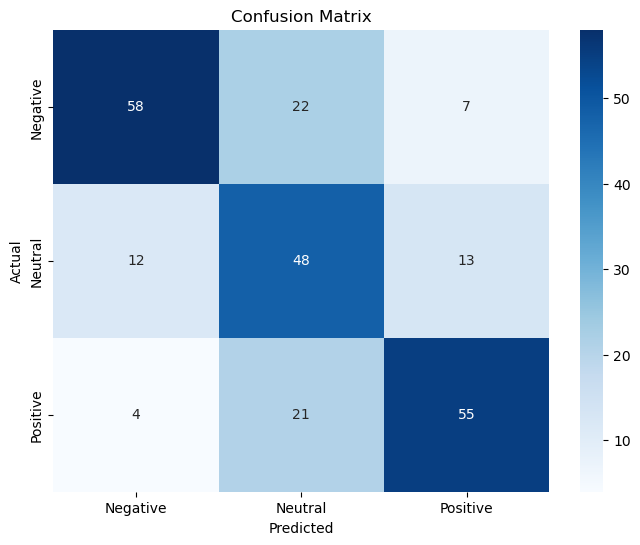

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('2_conf.pdf', format='pdf')
plt.show()

In [10]:
def analyze_sentiment(input_text):
    # Preprocess the input text
    input_text = input_text.lower()

    # Transform the input text using the same TF-IDF vectorizer
    input_tfidf = tfidf_vectorizer.transform([input_text])

    # Predict the sentiment for the input text
    predicted_sentiment = clf.predict(input_tfidf)[0]

    return predicted_sentiment

In [11]:
analyze_sentiment("I am going to buy apple stock. I love apple stock!")

1.0